In [12]:
!git clone https://github.com/ksideks/UCSD.git

Klonowanie do „UCSD”...
remote: Enumerating objects: 21346, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 21346 (delta 1), reused 6 (delta 1), pack-reused 21340
Pobieranie obiektów: 100% (21346/21346), 714.01 MiB | 14.08 MiB/s, gotowe.
Rozwiązywanie delt: 100% (2642/2642), gotowe.
Aktualizowanie plików: 100% (22645/22645), gotowe.


In [1]:
!pip install keras-layer-normalization

In [2]:
TestVideoFile = {}
TestVideoFile[1] = range(59,152)
TestVideoFile[2] = range(49,175)
TestVideoFile[3] = range(90,200)
TestVideoFile[4] = range(30,168)
TestVideoFile[5] = list(range(4,90)) + list(range(139,200))
TestVideoFile[6] = list(range(0,100)) + list(range(109,200))
TestVideoFile[7] = range(0,175)
TestVideoFile[8] = range(0,94)
TestVideoFile[9] = range(0,48)
TestVideoFile[10] = range(0,140)
TestVideoFile[11] = range(69,165)
TestVideoFile[12] = range(130,200)
TestVideoFile[13] = range(0,156)
TestVideoFile[14] = range(3,198)  # 0 200
TestVideoFile[15] = range(137,200)
TestVideoFile[16] = range(122,200)
TestVideoFile[17] = range(0,47)
TestVideoFile[18] = range(53,120)
TestVideoFile[19] = range(63,138)
TestVideoFile[20] = range(44,175)
TestVideoFile[21] = range(30,200)
TestVideoFile[22] = range(16,107)
TestVideoFile[23] = range(8,165)
TestVideoFile[24] = range(49,171)
TestVideoFile[25] = range(39,135)
TestVideoFile[26] = range(77,144)
TestVideoFile[27] = range(9,122)
TestVideoFile[28] = range(104,200)
TestVideoFile[29] = list(range(0,15)) + list(range(44,113))
TestVideoFile[30] = range(174,200)
TestVideoFile[31] = range(0,180)
TestVideoFile[32] = list(range(0,52)) + list(range(64,115))
TestVideoFile[33] = range(4,165)
TestVideoFile[34] = range(0,121)
TestVideoFile[35] = range(85,200)
TestVideoFile[36] = range(14,108)

In [3]:
#imports
from os import listdir
from os.path import isfile, join, isdir
from PIL import Image
import numpy as np
import shelve

import keras
import tensorflow as tf 
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, LayerNormalization
from keras.models import Sequential, load_model

from os import listdir
from os.path import isfile, join, isdir
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics


2021-11-10 14:02:54.424194: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-10 14:02:54.424241: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
class Config:
  DATASET_PATH ="UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train"
  TEST_PATH ="UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test"
  SINGLE_TEST_PATH = "UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test001"
  SINGLE_TEST_VIDEO_FILE = 1
  BATCH_SIZE =  32
  EPOCHS = 50
  MODEL_PATH = "UCSD/model_v6.hdf5"
  THRESHOLD = 0.95

In [5]:
def get_clips_by_step(step, frames_list, sequence_size):
   
    #data pre-processing, one volume has 10 clips, with different steps (1;2;3)
    volumes = []
    size = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 227, 227, 1))
    cnt = 0
    for start in range(0, step):
        for i in range(start, size, step):
            clip[cnt, :, :, 0] = frames_list[i]
            cnt = cnt + 1
            if cnt == sequence_size:
                volumes.append(np.copy(clip))
                cnt = 0
    return volumes


def get_training_set():
    clips = []
    for f in sorted(listdir(Config.DATASET_PATH)):
        if isdir(join(Config.DATASET_PATH, f)):
            all_frames = []
            for c in sorted(listdir(join(Config.DATASET_PATH, f))):
                if str(join(join(Config.DATASET_PATH, f), c))[-3:] == "tif":
                    img = Image.open(join(join(Config.DATASET_PATH, f), c)).resize((227, 227))
                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            for stride in range(1, 3):
                clips.extend(get_clips_by_step(step=stride, frames_list=all_frames, sequence_size=10))
    return clips

In [6]:
def get_model(reload_model=True): 
   
    #model is already saved, there's posibility to retrain it, but not until there's more memory RAM
    if not reload_model:
        return load_model(Config.MODEL_PATH,custom_objects={'LayerNormalization': LayerNormalization})

    #adding print checkpoints to see if model works
    print("starting training")
    training_set = get_training_set()
    training_set = np.array(training_set)
    print("got training set")

    training_set = training_set.reshape(-1,10,227,227,1)

    seq = Sequential() 

    #AUTOENCODER --> spatial part
    
    seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="valid", activation=None,), batch_input_shape=(None, 10, 227, 227, 1))) #resizing to 227, 227
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="valid", activation=None,)))
    seq.add(LayerNormalization())

    
    # Convolutional Long-short term memory --> temporal part
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())

    # AUTODECODER --> spatial part  

    seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="valid", activation=None,)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="valid", activation=None,)))
    seq.add(LayerNormalization())
    #seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))  

    print(seq.summary())  # SUMMARY Should be visible /seq.summary()


    seq.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=1e-3)) #, decay=1e-5, epsilon=1e-6)) #no decay and no epsilon #changing learning rate --> 1e-3; lr=1e-4; 1e-3 etc.
    seq.fit(training_set, training_set,
            batch_size=Config.BATCH_SIZE, epochs=Config.EPOCHS, shuffle=False)
    seq.save(Config.MODEL_PATH)
    return seq

In [7]:
def get_single_test():
    size = 200
    test = np.zeros(shape=(size, 227, 227, 1))
    cnt = 0
    for f in sorted(listdir(Config.SINGLE_TEST_PATH)):
        if str(join(Config.SINGLE_TEST_PATH, f))[-3:] == "tif":
            img = Image.open(join(Config.SINGLE_TEST_PATH, f)).resize((227, 227))
            img = np.array(img, dtype=np.float32) / 256.0
            test[cnt, :, :, 0] = img
            cnt = cnt + 1
    return test

In [8]:
def evaluate(reload_model=False):
    model = get_model(reload_model) #get_model(True) ->to retrain the model
    print("got model")
    test = get_single_test()
    print(test.shape)
    size = test.shape[0] - 10 + 1
    sequences = np.zeros((size, 10, 227, 227, 1))
    # apply the sliding window technique to get the sequences
    for i in range(0, size):
        clip = np.zeros((10, 227, 227, 1))
        for j in range(0, 10):
            clip[j] = test[i + j, :, :, :]
        sequences[i] = clip

    print("got data")

    # get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences,batch_size=4)

    #caluclating the Eculidean distance/norm2
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,size)])

    #anomaly score as = sa
    anomaly_score = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)

    #Regularity score -> sr
    regularity_score = 1.0 - anomaly_score

    # plot the regularity scores vs frames
    plt.plot(regularity_score)
    plt.ylabel('regularity score(t)')
    plt.xlabel('frame t')
    plt.show()

    return regularity_score

In [ ]:
pr = evaluate(False)  #checking for one video

2021-11-10 14:04:57.989150: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-10 14:04:57.989207: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-10 14:04:57.989237: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ml): /proc/driver/nvidia/version does not exist
2021-11-10 14:04:57.989651: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


got model
(200, 227, 227, 1)
got data


AUC:  0.9976958525345622
EER:  0.010752688172043012
EER THRESHOLD:  0.8995631916941942
Optimal threshold value is: 0.9048060541641455


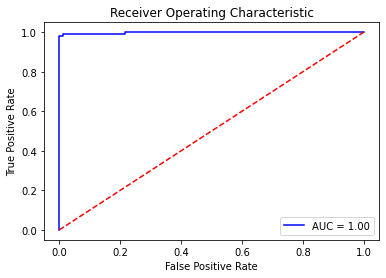

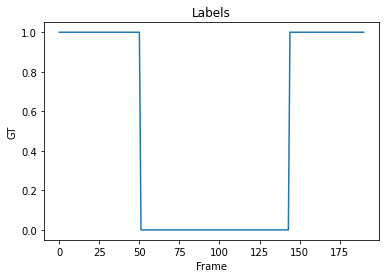

(0.9976958525345622, 0.010752688172043012)

In [ ]:
def plotROC(pr):
  y_pred = pr
  y_test = [1 for element in range(0, 200)]

  for i in TestVideoFile[Config.SINGLE_TEST_VIDEO_FILE]:
    y_test[i] = 0

  y_test = y_test[8:199] #testing with different removals to match number of regularity scores #different kinds still vary in 77%

  fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
  fnr = 1 - tpr
  auc = metrics.roc_auc_score(y_test, y_pred)

  eer_threshold = thresholds[np.nanargmin(np.absolute((fnr - fpr)))]
  eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]

  optimal = np.argmax(tpr - fpr)
  optimal_threshold = thresholds[optimal]


  #print("FPR: ", fpr)
  #print("TPR: ", tpr)
  #print("THRESHOLDS", thresholds)
  print("AUC: ", auc)
  print("EER: ", eer)
  print("EER THRESHOLD: ", eer_threshold)
  print("Optimal threshold value is:", optimal_threshold)

  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')  
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

  plt.plot(y_test)
  plt.title('Labels')  #labels(flags, 0-1) 
  plt.ylabel('GT')
  plt.xlabel('Frame')
  plt.show()

  return auc, eer

plotROC(pr)


PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test001
GT:  1
got model
(200, 256, 256, 1)
got data


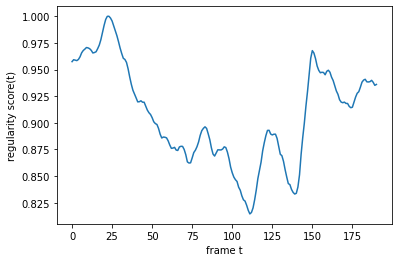

AUC:  0.9976958525345622
EER:  0.010752688172043012
EER THRESHOLD:  0.8995631925419086
Optimal threshold value is: 0.9048060545791026


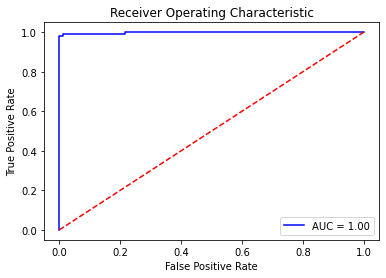

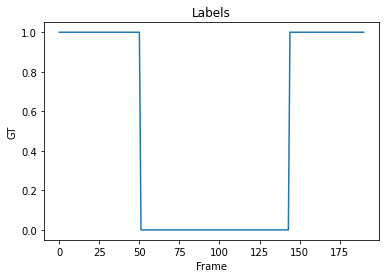

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test002
GT:  2
got model
(200, 256, 256, 1)
got data


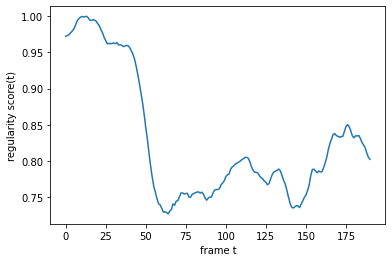

AUC:  0.9675213675213675
EER:  0.09523809523809523
EER THRESHOLD:  0.8302115669146188
Optimal threshold value is: 0.8048340217307672


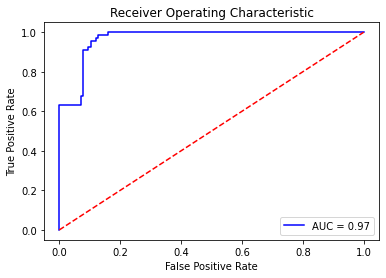

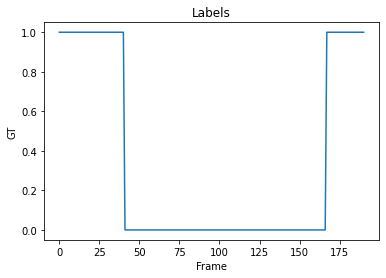

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test003
GT:  3
got model
(200, 256, 256, 1)
got data


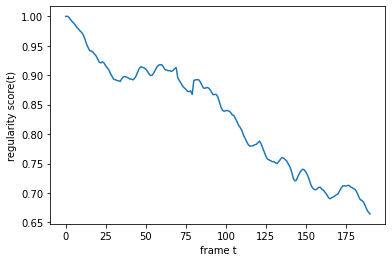

AUC:  0.9916088610427389
EER:  0.05504587155963303
EER THRESHOLD:  0.878545029799418
Optimal threshold value is: 0.8721717621940724


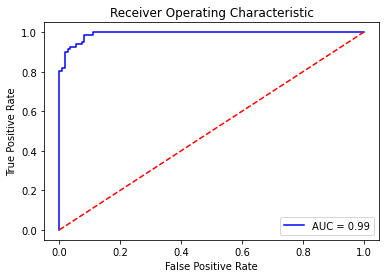

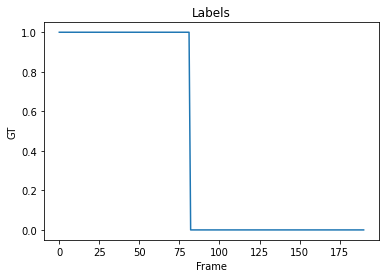

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test004
GT:  4
got model
(200, 256, 256, 1)
got data


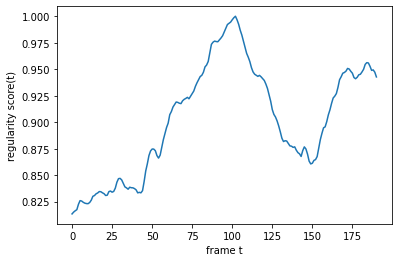

AUC:  0.42863002461033634
EER:  0.45652173913043476
EER THRESHOLD:  0.91192574830331
Optimal threshold value is: 0.9228094893882911


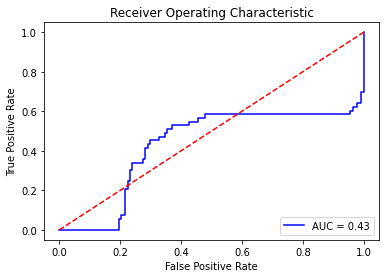

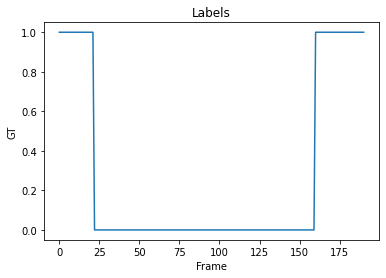

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test005
GT:  5
got model
(200, 256, 256, 1)
got data


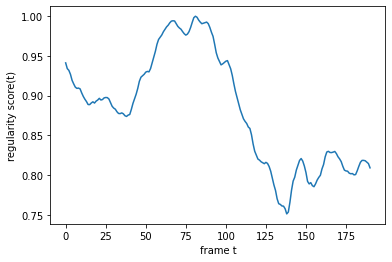

AUC:  0.6122448979591837
EER:  0.47183098591549294
EER THRESHOLD:  0.8901481278876989
Optimal threshold value is: 0.933833327282344


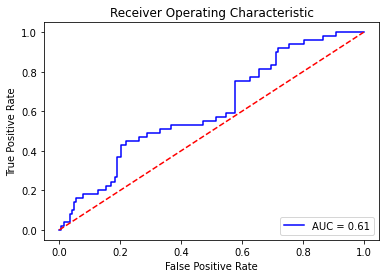

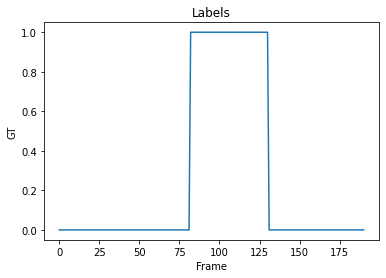

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test006
GT:  6
got model
(200, 256, 256, 1)
got data


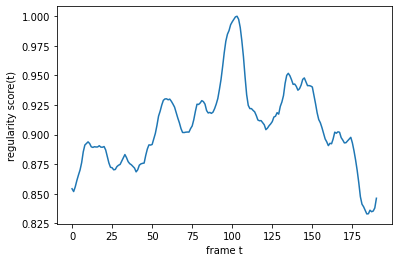

AUC:  0.9542124542124543
EER:  0.13736263736263737
EER THRESHOLD:  0.9387535775039926
Optimal threshold value is: 0.9381511812541062


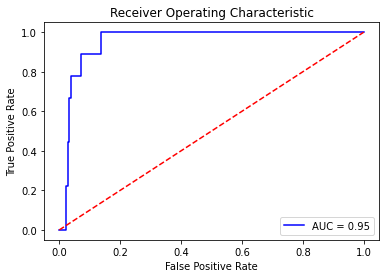

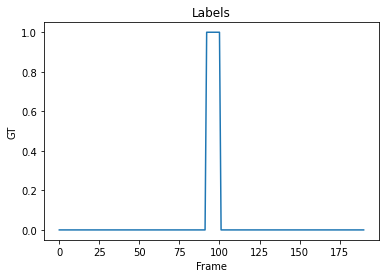

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test007
GT:  7
got model
(200, 256, 256, 1)
got data


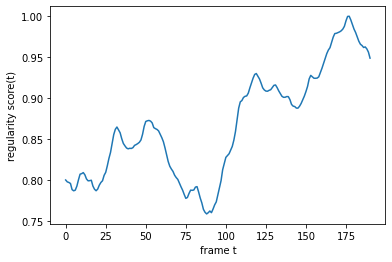

AUC:  0.9967564870259481
EER:  0.023952095808383235
EER THRESHOLD:  0.9544952277946812
Optimal threshold value is: 0.948983041658871


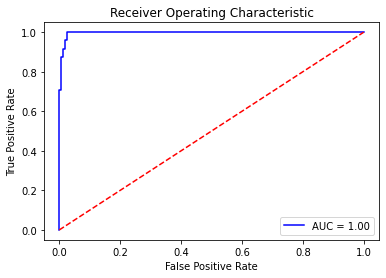

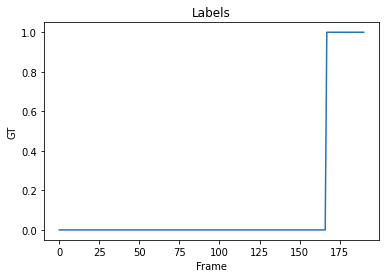

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test008
GT:  8
got model
(200, 256, 256, 1)
got data


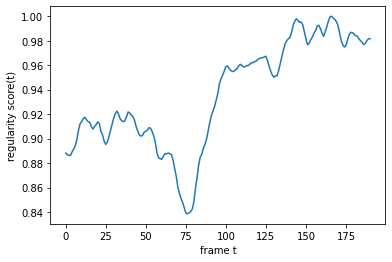

AUC:  0.9775193798449613
EER:  0.06976744186046512
EER THRESHOLD:  0.9191332967702129
Optimal threshold value is: 0.9226056061506211


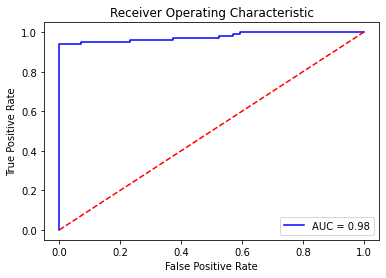

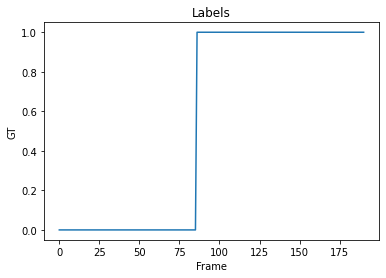

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test009
GT:  9
got model
(200, 256, 256, 1)
got data


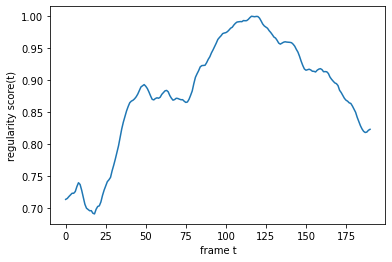

AUC:  0.9928807947019868
EER:  0.05
EER THRESHOLD:  0.8497030832213934
Optimal threshold value is: 0.8595177438283085


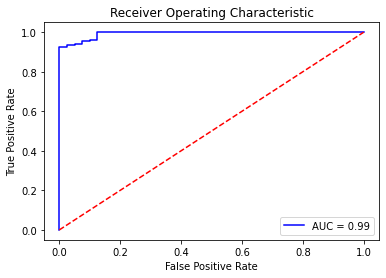

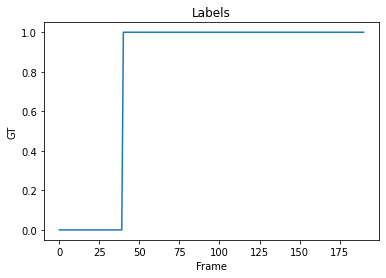

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test010
GT:  10
got model
(200, 256, 256, 1)
got data


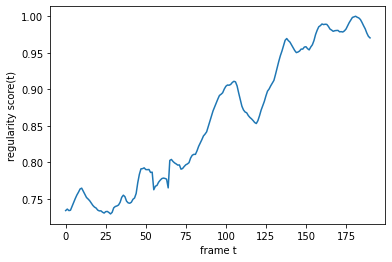

AUC:  1.0
EER:  0.0
EER THRESHOLD:  0.9295354017238942
Optimal threshold value is: 0.9295354017238942


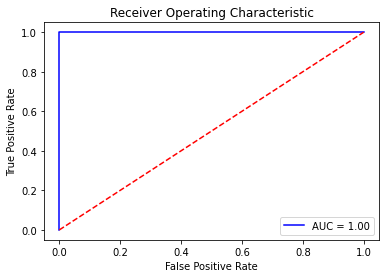

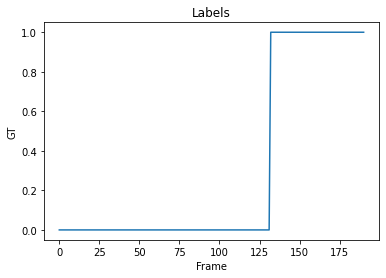

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test011
GT:  11
got model
(200, 256, 256, 1)
got data


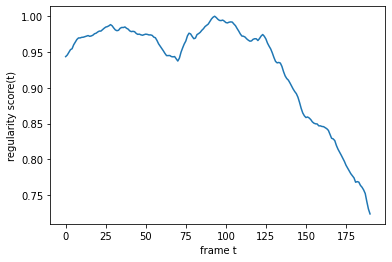

AUC:  0.42587719298245613
EER:  0.4791666666666667
EER THRESHOLD:  0.9677413382397391
Optimal threshold value is: 0.9696876174359549


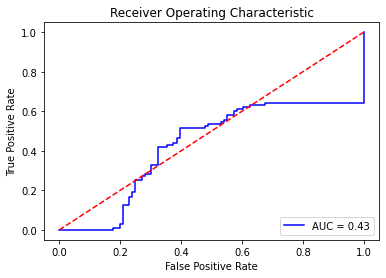

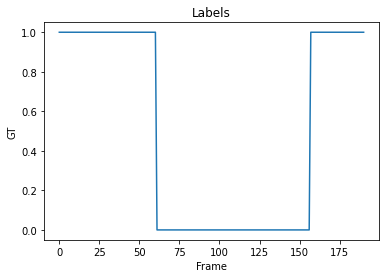

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test012
GT:  12
got model
(200, 256, 256, 1)
got data


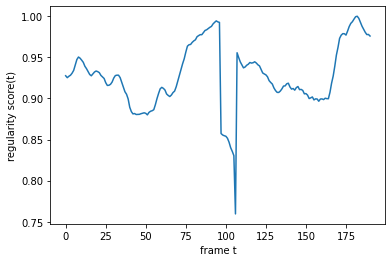

AUC:  0.47445949156569256
EER:  0.42028985507246375
EER THRESHOLD:  0.924268926557956
Optimal threshold value is: 0.9195772278706394


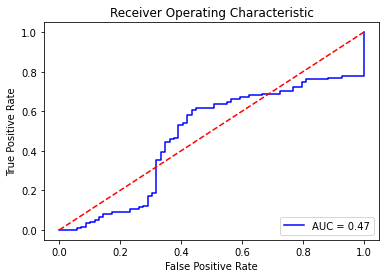

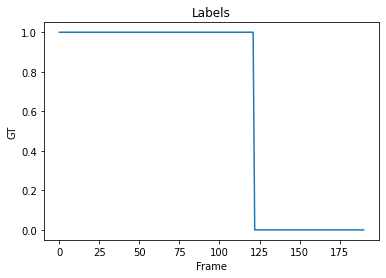

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test013
GT:  13
got model
(200, 256, 256, 1)
got data


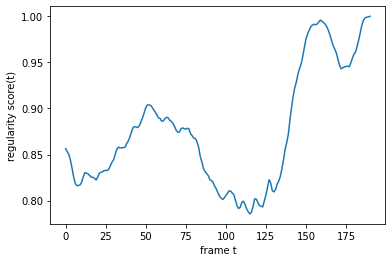

AUC:  0.9987429289754871
EER:  0.013513513513513514
EER THRESHOLD:  0.9431046185117768
Optimal threshold value is: 0.9429860856787033


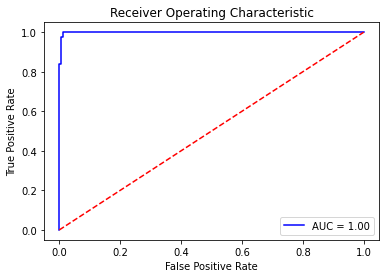

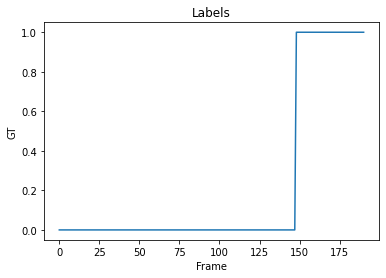

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test014
GT:  14
got model
(200, 256, 256, 1)
got data


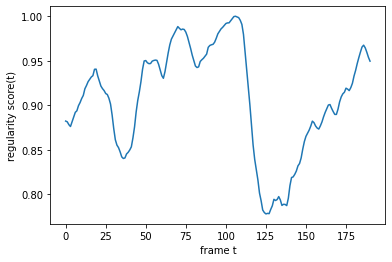

AUC:  0.7
EER:  0.3
EER THRESHOLD:  0.9495760153376893
Optimal threshold value is: 0.9495760153376893


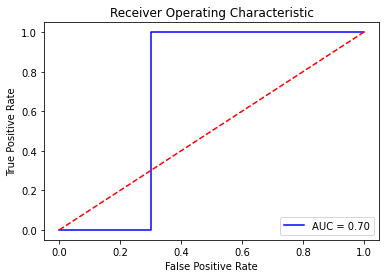

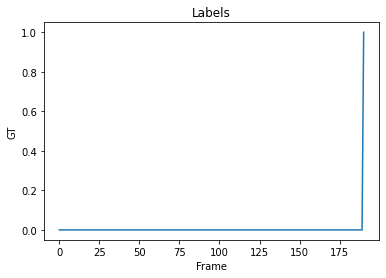

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test015
GT:  15
got model
(200, 256, 256, 1)
got data


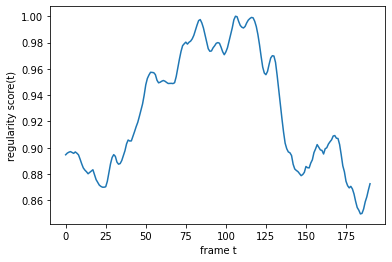

AUC:  0.8014503625906477
EER:  0.24193548387096775
EER THRESHOLD:  0.9028763868034605
Optimal threshold value is: 0.9122160809482901


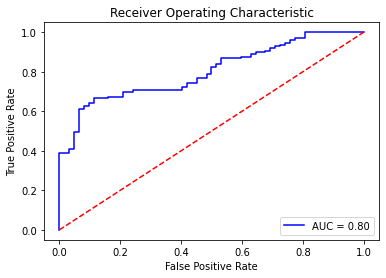

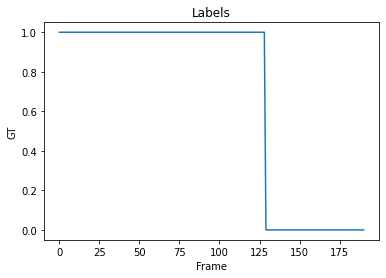

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test016
GT:  16
got model
(200, 256, 256, 1)
got data


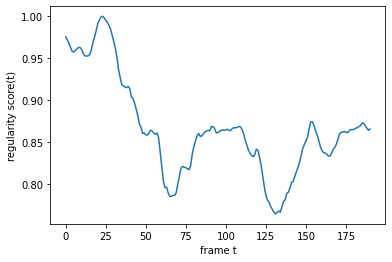

AUC:  0.7615629984051037
EER:  0.3116883116883117
EER THRESHOLD:  0.8604230130675852
Optimal threshold value is: 0.8570577007797239


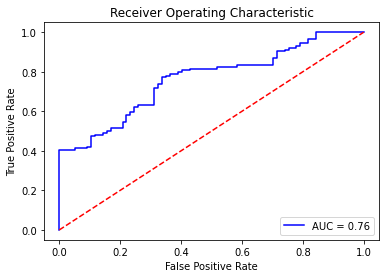

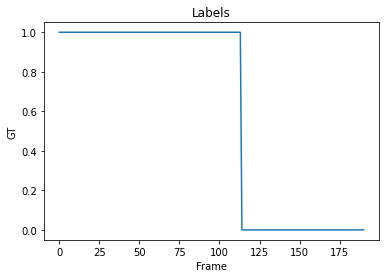

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test018
GT:  18
got model
(200, 256, 256, 1)
got data


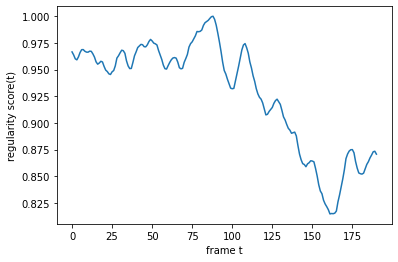

AUC:  0.13769860375541648
EER:  0.746268656716418
EER THRESHOLD:  0.9567672879307668
Optimal threshold value is: 2.0


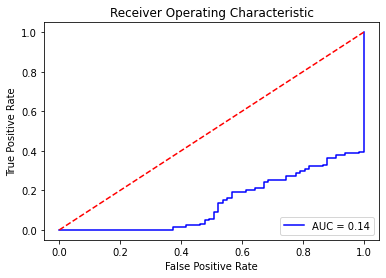

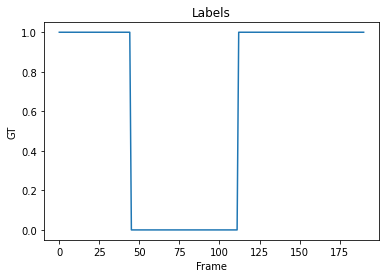

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test019
GT:  19
got model
(200, 256, 256, 1)
got data


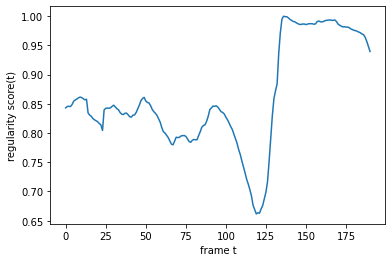

AUC:  0.9570114942528736
EER:  0.14666666666666667
EER THRESHOLD:  0.83391624416151
Optimal threshold value is: 0.8306753116191896


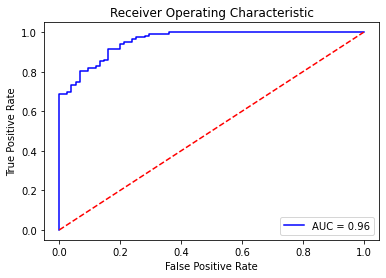

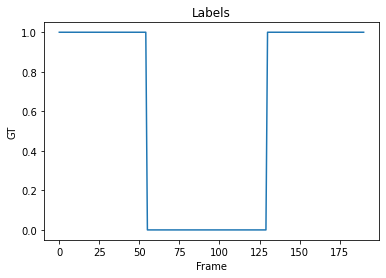

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test020
GT:  20
got model
(200, 256, 256, 1)
got data


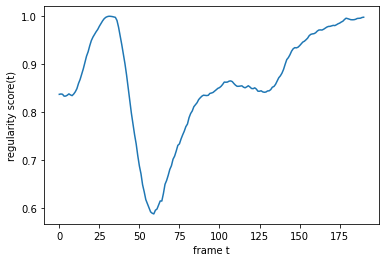

AUC:  0.8368956743002545
EER:  0.24427480916030533
EER THRESHOLD:  0.8903939119757489
Optimal threshold value is: 0.9773294570814733


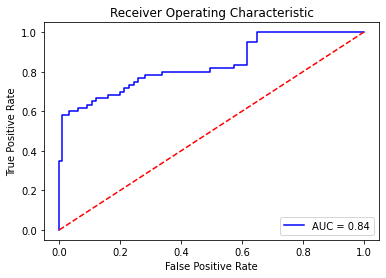

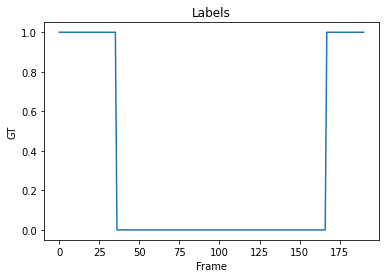

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test021
GT:  21
got model
(200, 256, 256, 1)
got data


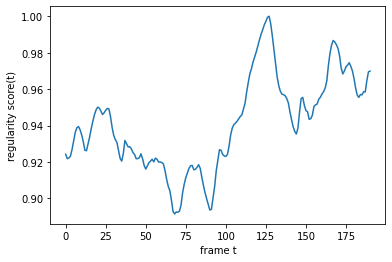

AUC:  0.43437331898870357
EER:  0.5562130177514792
EER THRESHOLD:  0.9363268199530123
Optimal threshold value is: 0.921823668837675


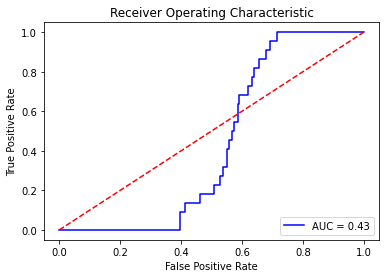

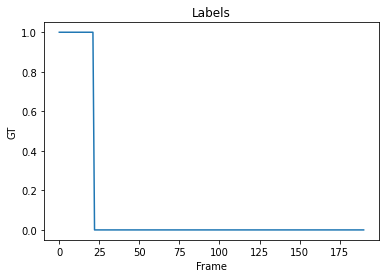

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test022
GT:  22
got model
(200, 256, 256, 1)
got data


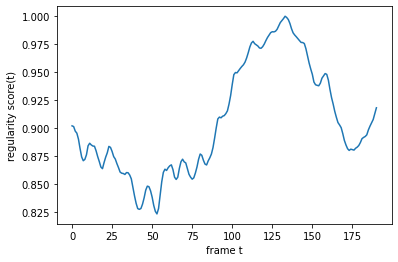

AUC:  0.9553846153846154
EER:  0.10989010989010989
EER THRESHOLD:  0.8870635974290093
Optimal threshold value is: 0.88000474213691


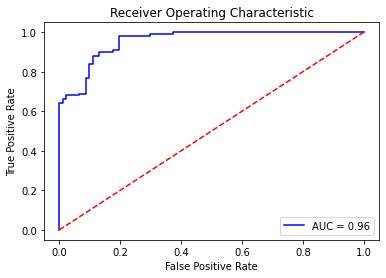

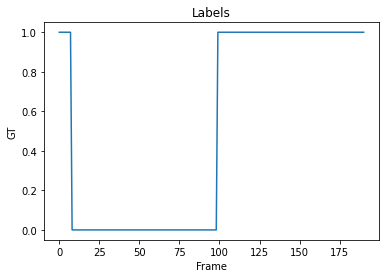

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test023
GT:  23
got model
(200, 256, 256, 1)
got data


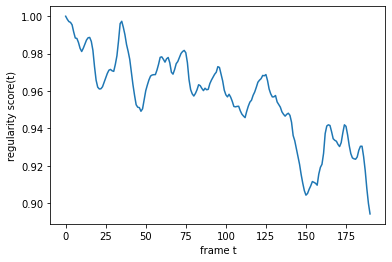

AUC:  0.07381041588609966
EER:  0.9044585987261147
EER THRESHOLD:  0.9433451825305206
Optimal threshold value is: 2.0


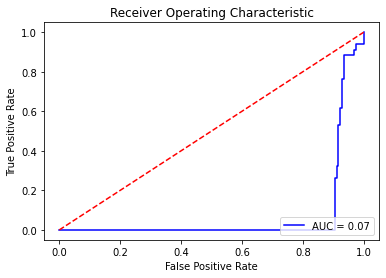

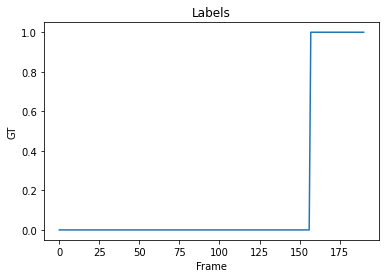

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test024
GT:  24
got model
(200, 256, 256, 1)
got data


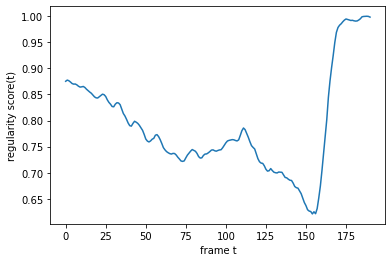

AUC:  0.9991684485626039
EER:  0.01639344262295082
EER THRESHOLD:  0.7952173310912495
Optimal threshold value is: 0.8019680493319719


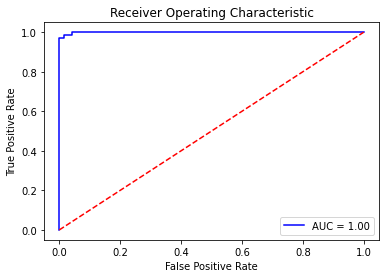

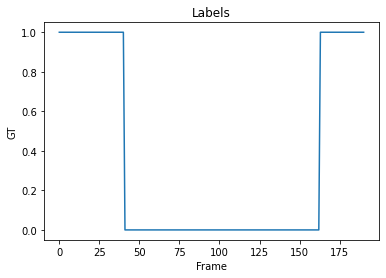

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test025
GT:  25
got model
(200, 256, 256, 1)
got data


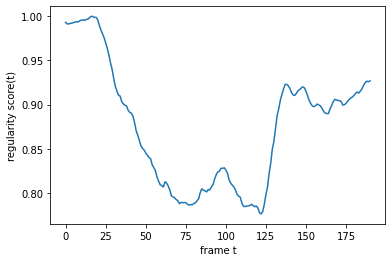

AUC:  0.9634868421052631
EER:  0.09375
EER THRESHOLD:  0.8923962298084841
Optimal threshold value is: 0.8875635674495833


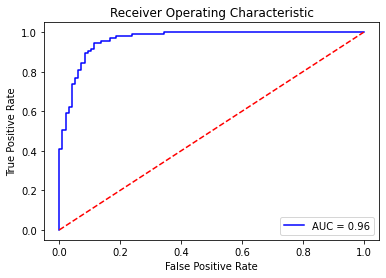

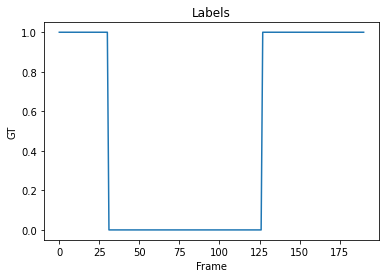

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test026
GT:  26
got model
(200, 256, 256, 1)
got data


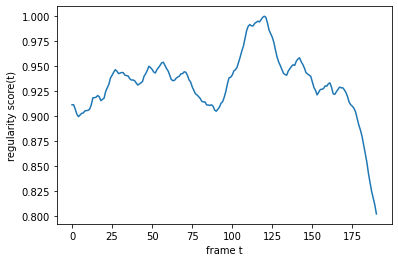

AUC:  0.3171641791044777
EER:  0.6268656716417911
EER THRESHOLD:  0.9382954655153324
Optimal threshold value is: 2.0


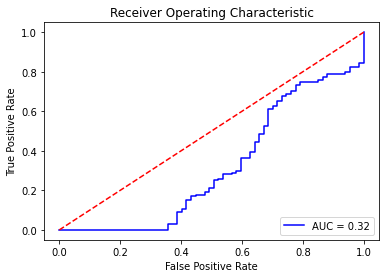

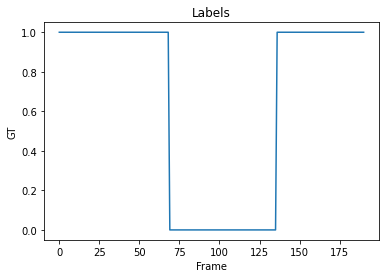

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test027
GT:  27
got model
(200, 256, 256, 1)
got data


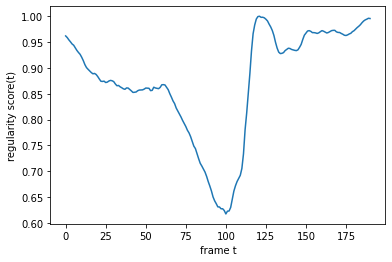

AUC:  0.9781030179260268
EER:  0.061946902654867256
EER THRESHOLD:  0.9305681868510169
Optimal threshold value is: 0.9277896296480792


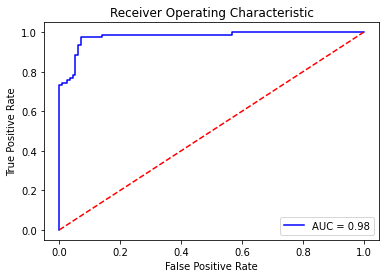

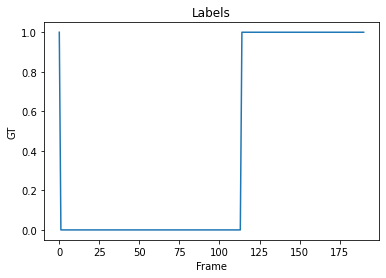

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test028
GT:  28
got model
(200, 256, 256, 1)
got data


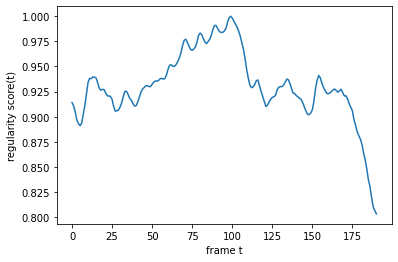

AUC:  0.6473684210526316
EER:  0.3894736842105263
EER THRESHOLD:  0.9279117191020056
Optimal threshold value is: 0.9341939253264233


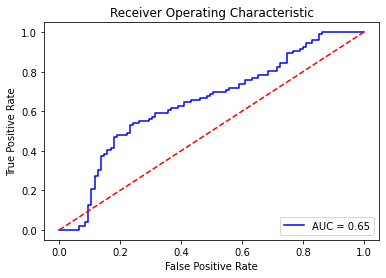

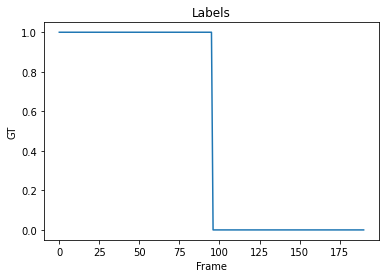

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test029
GT:  29
got model
(200, 256, 256, 1)
got data


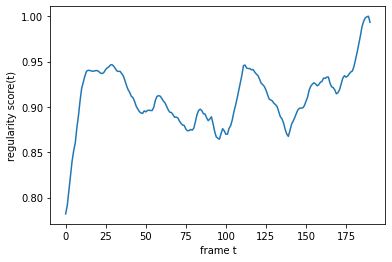

AUC:  0.8838672768878718
EER:  0.19736842105263158
EER THRESHOLD:  0.904507708168741
Optimal threshold value is: 0.9138318352999714


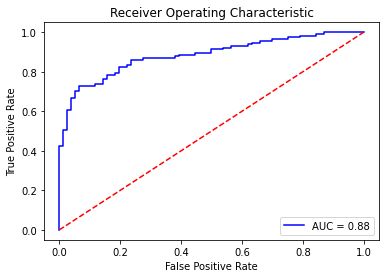

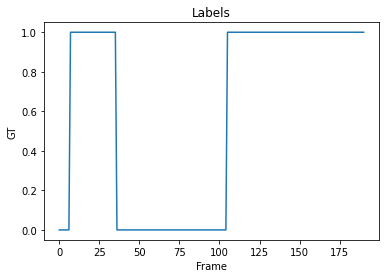

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test030
GT:  30
got model
(200, 256, 256, 1)
got data


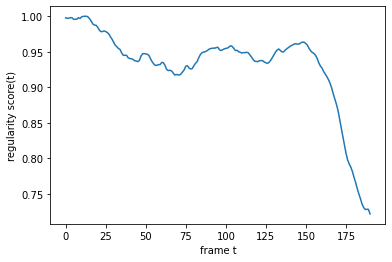

AUC:  1.0
EER:  0.0
EER THRESHOLD:  0.9059300383058098
Optimal threshold value is: 0.9059300383058098


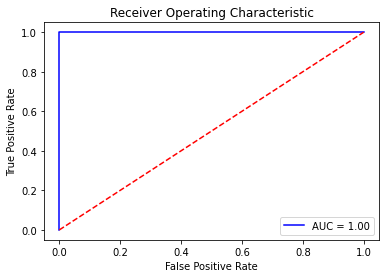

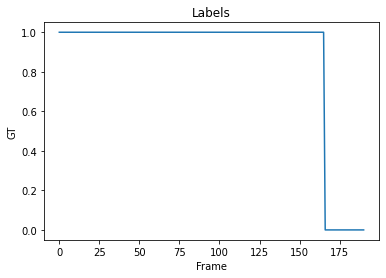

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test031
GT:  31
got model
(200, 256, 256, 1)
got data


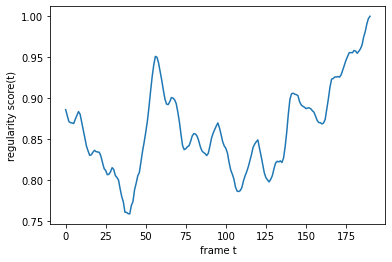

AUC:  0.9951040391676866
EER:  0.029069767441860465
EER THRESHOLD:  0.9323213573726755
Optimal threshold value is: 0.9287186920288892


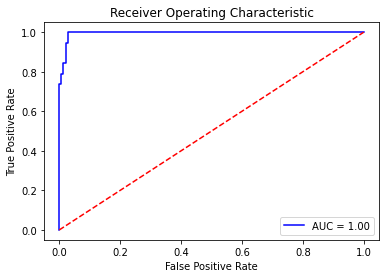

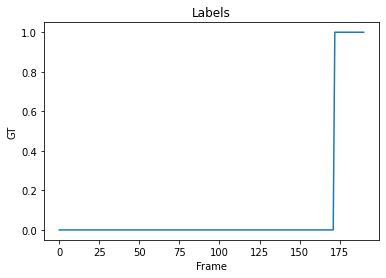

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test032
GT:  32
got model
(200, 256, 256, 1)
got data


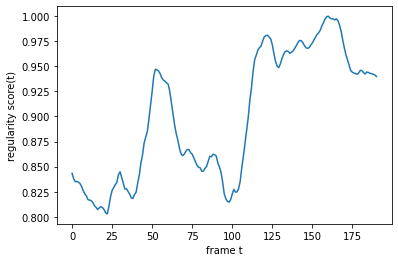

AUC:  0.9854166666666666
EER:  0.08421052631578947
EER THRESHOLD:  0.9032157662043856
Optimal threshold value is: 0.939924781982233


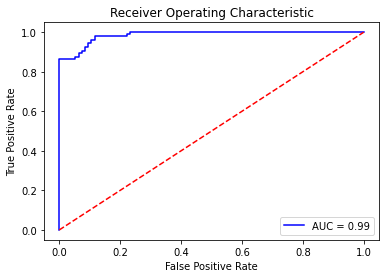

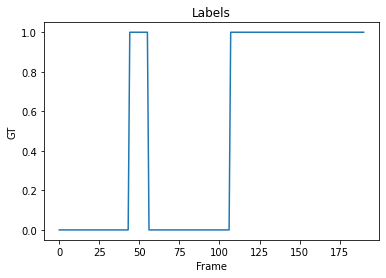

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test033
GT:  33
got model
(200, 256, 256, 1)
got data


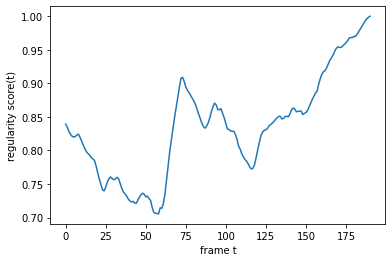

AUC:  0.997939303109779
EER:  0.03821656050955414
EER THRESHOLD:  0.8898278564298094
Optimal threshold value is: 0.8884196606928983


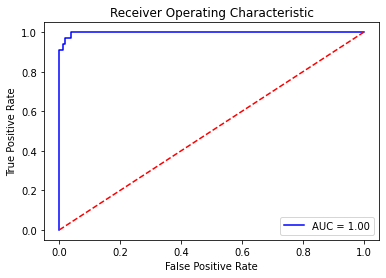

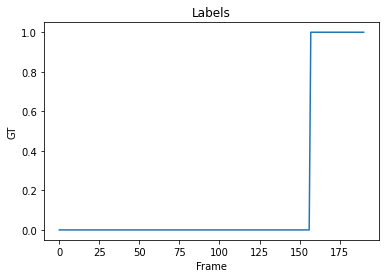

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test034
GT:  34
got model
(200, 256, 256, 1)
got data


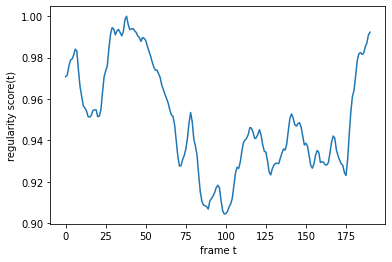

AUC:  0.3714545041978671
EER:  0.6371681415929203
EER THRESHOLD:  0.9410447752157627
Optimal threshold value is: 0.9230947103092899


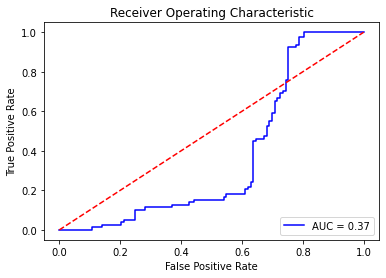

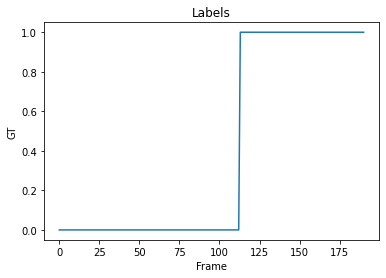

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test035
GT:  35
got model
(200, 256, 256, 1)
got data


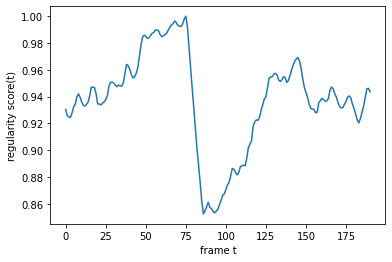

AUC:  0.8122579175210753
EER:  0.30701754385964913
EER THRESHOLD:  0.9420913823529713
Optimal threshold value is: 0.9467078424772211


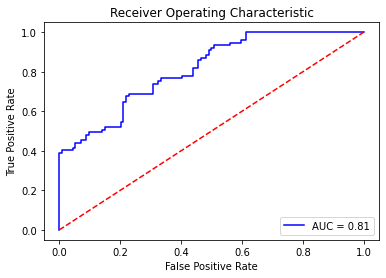

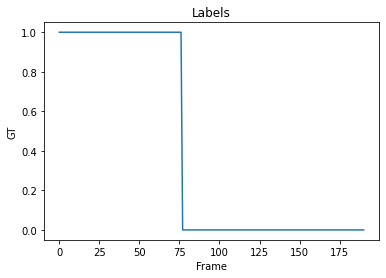

PATH:  /content/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test036
GT:  36
got model
(200, 256, 256, 1)
got data


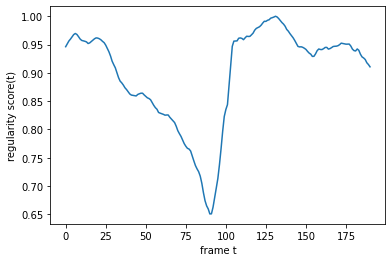

AUC:  0.8568765080061417
EER:  0.22340425531914893
EER THRESHOLD:  0.9378796285782439
Optimal threshold value is: 0.9106049451993841


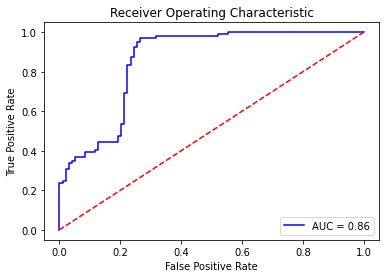

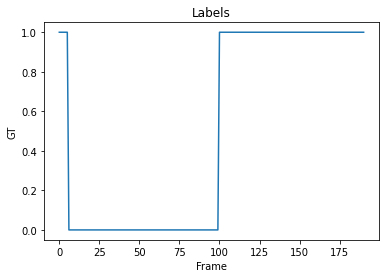

AUC:  0.7795584097385423
EER:  0.24427777605691117


In [ ]:
clips = []
# loop over the testing videos to get everysingle one
for f in sorted(listdir(Config.TEST_PATH)):
    if isdir(join(Config.TEST_PATH, f)):
      if not 'gt' in f:
        clips.append(join(Config.TEST_PATH, f))


scores = []

for i in range(len(clips)):
  if(i == 16): #skip clip 17 -> does not work 
    continue

  Config.SINGLE_TEST_PATH = clips[i]
  Config.SINGLE_TEST_VIDEO_FILE = i+1

  print("PATH: ", Config.SINGLE_TEST_PATH)
  print("GT: ", Config.SINGLE_TEST_VIDEO_FILE)

  pr = evaluate()
  scores.append(plotROC(pr))


mean = np.mean(scores, axis=0)   #calculating the mean value of all AUCs and EERs
#print(scores)
print("AUC: ", mean[0])
print("EER: ", mean[1])

In [ ]:
"""
#manually counting tp, fp, tn, fn  

#OUTCOME: very similar ROC and AUC, but this manual version would require changing the videos each time by hand

def multiTresh(pr):
    treshMin, treshMax, step=min(pr),max(pr),0.01
    treshold = treshMin
    dif=0
    rangeFrom, rangeTo = 59, 152+1  #range from the TestVideoFile[1]
    rate,pair=[],[]
      

    while(treshold<treshMax):
        treshold = treshold + step
        truePositive, falsePositive, falseNegative, trueNegative = 0,0,0,0 
      
        for ii in range(len(pr)):
            if pr[ii]<treshold and ii in range(rangeFrom, rangeTo):
                truePositive +=1
            if pr[ii]<treshold and ii not in range(rangeFrom, rangeTo):
                falsePositive += 1  
            if pr[ii]>treshold and ii in range(rangeFrom, rangeTo):
                falseNegative +=1
            if pr[ii]>treshold and ii not in range(rangeFrom, rangeTo):
                trueNegative += 1 
        pair=[]
        tpr=truePositive/(truePositive  + falseNegative)
        pair.append(tpr)
        fpr=falsePositive/(trueNegative+ falsePositive )
        pair.append(fpr)
        rate.append(pair)
    return rate


pairs=multiTresh(pr)
for ii in range(len(pairs)):
    print(pairs[ii]) 

roc_point = pairs    
pivot = pd.DataFrame(roc_point, columns = ["x", "y"])
pivot

#ROC
plt.scatter(pivot.y, pivot.x)
plt.plot([0,1])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

#AUC
from numpy import trapz
auc = np.trapz(pivot.x, pivot.y)
auc
"""

'\n#manually counting tp, fp, tn, fn  \n\n#OUTCOME: very similar ROC and AUC, but this manual version would require changing the videos each time by hand\n\ndef multiTresh(pr):\n    treshMin, treshMax, step=min(pr),max(pr),0.01\n    treshold = treshMin\n    dif=0\n    rangeFrom, rangeTo = 59, 152+1  #range from the TestVideoFile[1]\n    rate,pair=[],[]\n      \n\n    while(treshold<treshMax):\n        treshold = treshold + step\n        truePositive, falsePositive, falseNegative, trueNegative = 0,0,0,0 \n      \n        for ii in range(len(pr)):\n            if pr[ii]<treshold and ii in range(rangeFrom, rangeTo):\n                truePositive +=1\n            if pr[ii]<treshold and ii not in range(rangeFrom, rangeTo):\n                falsePositive += 1  \n            if pr[ii]>treshold and ii in range(rangeFrom, rangeTo):\n                falseNegative +=1\n            if pr[ii]>treshold and ii not in range(rangeFrom, rangeTo):\n                trueNegative += 1 \n        pair=[]\n   